Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from ipywidgets import interact, FloatSlider, IntSlider
from scipy.stats import t
from scipy.stats import norm
from ipywidgets import interact
from statsmodels.stats.multitest import fdrcorrection


Parametes

In [3]:
# Parameters
alpha = 0.05
sampling_rate = 30000  # Hz
refractory_period = 0.002  # 2 ms
min_distance = int(refractory_period * sampling_rate)
time_to_rise = 0.001  # 1 ms
window_size = int(time_to_rise * sampling_rate * 3)  # Further extended window size

Function for filtering

In [4]:
def band_pass_filter(signal, lowcut, highcut, sampling_rate=30000):
    nyquist = 0.5 * sampling_rate
    b, a = butter(2, [lowcut / nyquist, highcut / nyquist], btype="band")
    return filtfilt(b, a, signal)


Apply FDR correction

In [5]:
def apply_fdr(signal, alpha):
    p_values = 2 * (1 - norm.cdf(np.abs(filtered_signal / np.std(filtered_signal))))
    print(f"Min p-value: {np.min(p_values)}, Max p-value: {np.max(p_values)}")
    significant, corrected_p_values = fdrcorrection(p_values, alpha=alpha)
    return significant

def detect_spikes_with_fdr(signal, significant_indices, min_distance):
    spikes = []
    for idx in significant_indices:
        if len(spikes) == 0 or idx - spikes[-1] > min_distance:
            spikes.append(idx)
    return np.array(spikes)


Detect significat spikes

In [6]:
def detect_spikes(signal, lower_threshold, upper_threshold, significant, min_distance):
    positive_spikes = detect_spikes_with_fdr(
        signal, np.where((signal > upper_threshold) & significant)[0], min_distance
    )
    negative_spikes = detect_spikes_with_fdr(
        signal, np.where((signal < lower_threshold) & significant)[0], min_distance
    )
    return positive_spikes, negative_spikes


Plot functions

Interactive plot for signal with spikes

In [7]:
# Interactive plot for signal with spikes
from ipywidgets import interact, IntRangeSlider


def interactive_signal_plot_with_zoom(
    signal, positive_indices, positive_values, negative_indices, negative_values, positive_fdr, negative_fdr
):
    def plot(x_range):
        x_min, x_max = x_range
        plt.figure(figsize=(12, 6))
        plt.plot(signal, color="lightblue", label="Filtered Signal")
        if not np.isnan(positive_fdr):
            plt.axhline(positive_fdr, color="green", linestyle="--", label="Positive FDR Threshold")
        if not np.isnan(negative_fdr):
            plt.axhline(negative_fdr, color="green", linestyle="--", label="Negative FDR Threshold")
        plt.scatter(
            positive_indices, positive_values, color="red", label="Positive Spikes", zorder=10, edgecolors="black"
        )
        plt.scatter(
            negative_indices, negative_values, color="blue", label="Negative Spikes", zorder=10, edgecolors="black"
        )

        # Add mean lines
        if len(positive_values) > 0:
            mean_positive_amplitude = np.mean(positive_values)
            plt.axhline(mean_positive_amplitude, color="red", linestyle="dotted", label="Mean Positive Spike Amplitude")
            mean_positive_index = np.mean(positive_indices)
            plt.axvline(mean_positive_index, color="red", linestyle="dotted", label="Mean Positive Spike Index")
        if len(negative_values) > 0:
            mean_negative_amplitude = np.mean(negative_values)
            plt.axhline(
                mean_negative_amplitude, color="blue", linestyle="dotted", label="Mean Negative Spike Amplitude"
            )
            mean_negative_index = np.mean(negative_indices)
            plt.axvline(mean_negative_index, color="blue", linestyle="dotted", label="Mean Negative Spike Index")

        plt.xlim(x_min, x_max)
        plt.title("Interactive Signal with Detected Spikes")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude (µV)")
        plt.legend(loc="lower left", fontsize=8)
        plt.grid()
        plt.tight_layout()
        plt.show()

    # Create IntRangeSlider for zoom
    x_slider = IntRangeSlider(
        value=[0, len(signal)],
        min=0,
        max=len(signal),
        step=100,
        description="X Range:",
        continuous_update=False,
    )

    # Connect slider to plot function
    interact(plot, x_range=x_slider)


In [8]:
def histogram_plot(signal, positive_spikes, negative_spikes, positive_threshold, negative_threshold):
    x = np.linspace(signal.min(), signal.max(), 1000)
    hist, bins = np.histogram(signal, bins=50, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    pdf = (1 / (np.std(signal) * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - np.mean(signal)) / np.std(signal)) ** 2)

    plt.figure(figsize=(12, 6))
    plt.bar(bin_centers, hist, width=(bins[1] - bins[0]), alpha=0.6, label="Signal Histogram")
    plt.plot(x, pdf, color="blue", label="Normal Distribution", linewidth=2)
    if not np.isnan(positive_threshold):
        plt.axvline(positive_threshold, color="green", linestyle="--", label="Positive FDR Threshold")
    if not np.isnan(negative_threshold):
        plt.axvline(negative_threshold, color="green", linestyle="--", label="Negative FDR Threshold")
    plt.scatter(positive_spikes, np.zeros_like(positive_spikes), color="red", label="Positive Spikes", zorder=10)
    plt.scatter(negative_spikes, np.zeros_like(negative_spikes), color="blue", label="Negative Spikes", zorder=10)

    plt.title("Histogram with Normal Distribution")
    plt.xlabel("Amplitude (µV)")
    plt.ylabel("Density")
    plt.legend(loc="lower left", fontsize=8)
    plt.grid()
    plt.tight_layout()
    plt.show()


Main code

In [9]:
# Load and preprocess the signal
signal = np.load("C:\\test1\\matan_bootcamp_python\\bic13-ch259.npy")[:30000]
filtered_signal = band_pass_filter(signal, lowcut=300, highcut=3000)
# Apply FDR correction
significant = apply_fdr(filtered_signal, alpha)

# Calculate p-values for FDR
p_values = 2 * (1 - norm.cdf(np.abs((filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal))))
print(f"Min p-value: {np.min(p_values)}, Max p-value: {np.max(p_values)}")

# Debugging FDR significant counts
print(f"Number of significant values: {np.sum(significant)}")
print(f"Number of significant positive values: {np.sum(significant & (filtered_signal > 0))}")
print(f"Number of significant negative values: {np.sum(significant & (filtered_signal < 0))}")

# Detect positive and negative spikes separately using FDR
positive_spike_indices, negative_spike_indices = detect_spikes(
    filtered_signal, lower_threshold=-20, upper_threshold=20, significant=significant, min_distance=min_distance
)

positive_spike_values = filtered_signal[positive_spike_indices]
negative_spike_values = filtered_signal[negative_spike_indices]

# Calculate FDR thresholds
positive_fdr = (
    np.min(filtered_signal[(filtered_signal > 0) & significant])
    if np.any((filtered_signal > 0) & significant)
    else np.nan
)
negative_fdr = (
    np.max(filtered_signal[(filtered_signal < 0) & significant])
    if np.any((filtered_signal < 0) & significant)
    else np.nan
)
print(f"Total number of values in signal: {len(filtered_signal)}")
print(f"Number of non-significant values: {len(filtered_signal) - np.sum(significant)}")


Min p-value: 0.0, Max p-value: 0.9998832690328217
Min p-value: 0.0, Max p-value: 0.9999425373121074
Number of significant values: 218
Number of significant positive values: 165
Number of significant negative values: 53
Total number of values in signal: 30000
Number of non-significant values: 29782


Plot results

interactive(children=(IntRangeSlider(value=(0, 30000), continuous_update=False, description='X Range:', max=30…

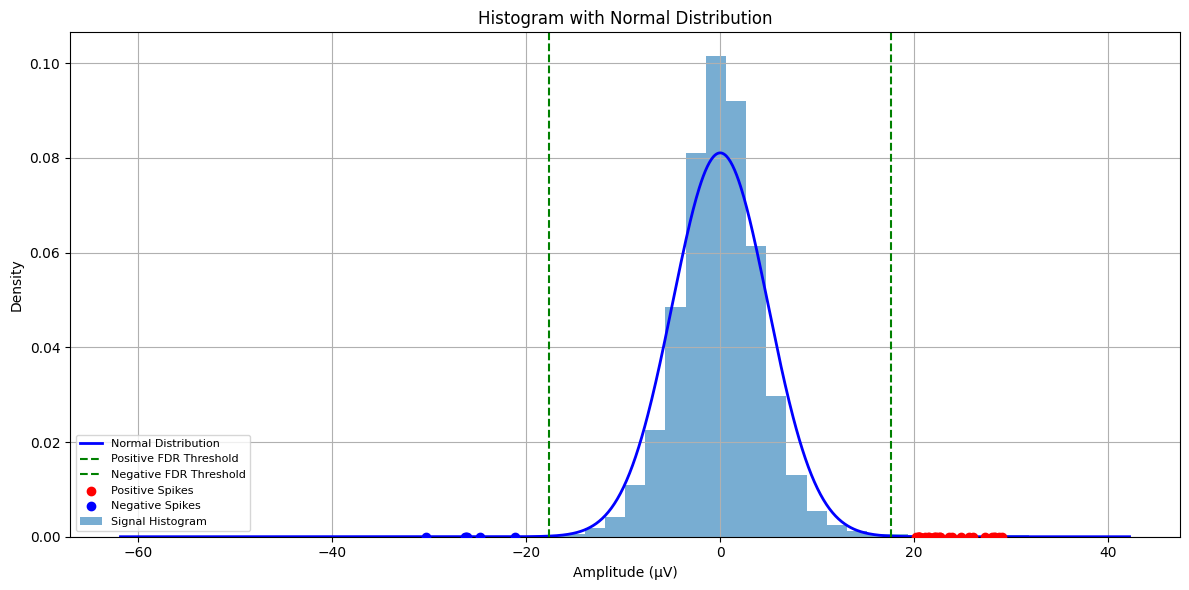

Mean Negative Spike Amplitude: -25.80 µV
Mean Positive Spike Amplitude: 23.63 µV
Number of positive spikes detected: 26
Number of negative spikes detected: 6


In [10]:
# Interactive signal plot

interactive_signal_plot_with_zoom(
    filtered_signal,
    positive_spike_indices,
    positive_spike_values,
    negative_spike_indices,
    negative_spike_values,
    positive_fdr=positive_fdr,
    negative_fdr=negative_fdr,
)

# Interactive histogram plot
histogram_plot(
    filtered_signal,
    positive_spike_values,
    negative_spike_values,
    positive_threshold=positive_fdr,
    negative_threshold=negative_fdr,
)

# Calculate mean of detected spikes
if len(negative_spike_values) > 0 or len(positive_spike_values) > 0:
    mean_negative_amplitude = np.mean(negative_spike_values) if len(negative_spike_values) > 0 else 0
    mean_positive_amplitude = np.mean(positive_spike_values) if len(positive_spike_values) > 0 else 0
    print(f"Mean Negative Spike Amplitude: {mean_negative_amplitude:.2f} µV")
    print(f"Mean Positive Spike Amplitude: {mean_positive_amplitude:.2f} µV")
else:
    print("No spikes detected.")
print(f"Number of positive spikes detected: {len(positive_spike_indices)}")
print(f"Number of negative spikes detected: {len(negative_spike_indices)}")
